In [ ]:
from google.colab import drive
import os

drive.mount("/content/drive")
os.chdir("drive/MyDrive/Tesis/dt")

Mounted at /content/drive


In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.5 MB/s eta 0:00:00


In [ ]:
from traffic_data import METRLADatasetLoader # descarga de datos
import numpy as np # manipulacion de datos
import matplotlib.pyplot as plt # graficar
import torch # crear modelos
from torch.utils.data import TensorDataset, DataLoader # manipular dataset
import torch.nn as nn # para usar las capas predefinidas en torch
import torch.optim as optim # para poder utilizar adam como el optimizador
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch

In [ ]:
# cargamos los datos
loader = METRLADatasetLoader()
adj, weig, x, y = loader.get_dataset(num_timesteps_in=12,
                                     num_timesteps_out=1)

In [ ]:
# omitiremos la variable del tiempo
x = [i[:, 0, :] for i in x]

In [ ]:
adj = torch.tensor(adj)

In [ ]:
print(len(x), len(y)) # instancias para entrenamiento
print(x[0].shape) # cada instancia tiene 207 nodos en 12 momentos
print(y[0].shape) # el ground truth es el grafo en el siguiente momento

34260 34260
(207, 12)
(207, 1)


In [ ]:
# convertimos la lista a un tensor aumentando una dimension mas
# primero convertimos a array porque es mas eficiente
X = torch.tensor(np.array(x)).permute(0, 2, 1).unsqueeze(-1)
Y = torch.tensor(np.array(y))
print(X.shape)
print(Y.shape)

torch.Size([34260, 12, 207, 1])
torch.Size([34260, 207, 1])


In [ ]:
# particionamos en train y test y cargamos los datos en objetos
# DataLoader para mejorar la eficiencia

train_p = 0.8 # porcentaje de training
batch_size = 256

train_size = int(train_p * len(X))
test_size = len(X) - train_size

X_train, X_test = torch.split(X, [train_size, test_size])
Y_train, Y_test = torch.split(Y, [train_size, test_size])

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=int(test_size),
                         shuffle=False, drop_last=True)

In [ ]:
X_train.shape

torch.Size([27408, 12, 207, 1])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class GCN_LSTM_Model(nn.Module):
    def __init__(self, node_feature_size, hidden_dim_gat, hidden_dim_lstm, lstm_layers, output_size, num_nodes):
        super(GCN_LSTM_Model, self).__init__()
        self.gcn_conv = GCNConv(node_feature_size, hidden_dim_gat)
        self.lstm = nn.LSTM(hidden_dim_gat * num_nodes, hidden_dim_lstm * num_nodes, lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim_lstm * num_nodes, output_size * num_nodes)
        self.num_nodes = num_nodes

    def forward(self, graph_sequence, edge_index):
        batch_size, seq_len, num_nodes, node_feature_size = graph_sequence.size()

        # Preparar las secuencias de grafos para GCNConv
        graph_sequence = graph_sequence.view(batch_size * seq_len, num_nodes, node_feature_size)
        x = graph_sequence.view(-1, node_feature_size)  # (batch_size * seq_len * num_nodes) x node_feature_size

        # Ajustar edge_index para batch processing
        edge_index_batch = edge_index.repeat(1, batch_size * seq_len)
        offset = torch.arange(0, batch_size * seq_len * num_nodes, step=num_nodes, dtype=torch.long).repeat_interleave(edge_index.size(1))
        offset = offset.to(device)
        edge_index_batch = edge_index_batch + offset

        # Procesar todos los grafos en la secuencia de una vez con GATConv
        gcn_output = self.gcn_conv(x, edge_index_batch)
        gcn_output = gcn_output.view(batch_size, seq_len, num_nodes, -1) # -1 = hidden_dim para las features de cada nodo

        # Pasar las salidas de GCNConv a LSTM
        gcn_output = gcn_output.view(batch_size, seq_len, -1)  # batch_size x seq_len x (num_nodes * hidden_dim)
        lstm_out, _ = self.lstm(gcn_output)

        # Predecir el siguiente estado del grafo
        lstm_out = lstm_out[:, -1, :]  # batch_size x hidden_dim
        out = self.fc(lstm_out)
        out = out.view(batch_size, num_nodes, -1)  # batch_size x num_nodes x output_size

        return out

In [ ]:
node_feature_size = 1
hidden_dim_gcn = 1
hidden_dim_lstm = 2
lstm_layers = 2
output_size = 1
num_nodes = X_train.size(2)
mean = 54.40592829587626
std = 19.493739270573094

In [ ]:
model = GCN_LSTM_Model(node_feature_size, hidden_dim_gcn, hidden_dim_lstm, lstm_layers, output_size, num_nodes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
adj = adj.to(device)

In [ ]:
def inverse_transform(X, mean = 54.40592829587626, std = 19.493739270573094):
    Y = X * std
    Y += mean
    return(Y)

In [ ]:
import torch
import numpy as np

# Definición de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Listas para almacenar la pérdida de cada batch
lossi = []
lossi_test = []
lossi_test_r = []

# Entrenamiento del modelo
num_epochs = 20
i = 0
xs = [0]

# Evaluación inicial en el conjunto de prueba
with torch.no_grad():
    model.eval()
    for X_batch, Y_batch in test_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        outputs = model(X_batch, adj)
        loss_test = criterion(outputs, Y_batch)
        lossi_test.append(loss_test.item())

# Ciclo de entrenamiento por épocas
for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    epoch_test_losses = []
    epoch_test_losses_r = []

    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        # Forward
        outputs = model(X_batch, adj)
        loss = criterion(outputs, Y_batch)
        epoch_losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        i += 1

    # Calcular y guardar el promedio de las pérdidas de la época
    lossi.append(np.mean(epoch_losses))
    xs.append(i)

    # Evaluación en el conjunto de prueba después de cada época
    with torch.no_grad():
        model.eval()
        for X_batch, Y_batch in test_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch, adj)
            outputs_real = inverse_transform(outputs, mean, std)
            Y_real = inverse_transform(Y_batch, mean, std)
            loss_test = criterion(outputs, Y_batch)
            epoch_test_losses.append(loss_test.item())
            loss_test_r = criterion(outputs_real, Y_real)
            epoch_test_losses_r.append(loss_test_r.item())

    # Calcular y guardar el promedio de las pérdidas de prueba de la época
    lossi_test.append(np.mean(epoch_test_losses))
    lossi_test_r.append(np.mean(epoch_test_losses_r))

    # Imprimir las pérdidas promedio
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {lossi[-1]:.4f}, Average Test Loss: {lossi_test[-1]:.4f}, Average Training Loss: {lossi[-1]:.4f}, Average Test Loss Real: {lossi_test_r[-1]:.4f}')

# Calcular el promedio global de las pérdidas de entrenamiento y prueba
global_avg_training_loss = np.mean(lossi)
global_avg_test_loss = np.mean(lossi_test)
global_avg_test_loss_r = np.mean(lossi_test_r)

print(f'Global Average Training Loss: {global_avg_training_loss:.4f}')
print(f'Global Average Test Loss: {global_avg_test_loss:.4f}')
print(f'Global Average Test Loss real: {global_avg_test_loss_r:.4f}')

Epoch [1/20], Average Training Loss: 0.5511, Average Test Loss: 0.4314, Average Training Loss: 0.5511, Average Test Loss Real: 163.9527
Epoch [2/20], Average Training Loss: 0.3299, Average Test Loss: 0.3492, Average Training Loss: 0.3299, Average Test Loss Real: 132.6909
Epoch [3/20], Average Training Loss: 0.2785, Average Test Loss: 0.3169, Average Training Loss: 0.2785, Average Test Loss Real: 120.4175
Epoch [4/20], Average Training Loss: 0.2283, Average Test Loss: 0.2987, Average Training Loss: 0.2283, Average Test Loss Real: 113.5253
Epoch [5/20], Average Training Loss: 0.1996, Average Test Loss: 0.2838, Average Training Loss: 0.1996, Average Test Loss Real: 107.8346
Epoch [6/20], Average Training Loss: 0.1837, Average Test Loss: 0.2731, Average Training Loss: 0.1837, Average Test Loss Real: 103.7679
Epoch [7/20], Average Training Loss: 0.1734, Average Test Loss: 0.2658, Average Training Loss: 0.1734, Average Test Loss Real: 101.0229
Epoch [8/20], Average Training Loss: 0.1661, Ave

In [ ]:
import torch

def calculate_rmse(y_true, y_pred):
    mse = torch.mean((y_true - y_pred) ** 2, axis=0)  # Promedio por pasos de tiempo
    rmse = torch.sqrt(mse)
    return torch.mean(rmse)  # Promedio sobre todos los pasos de tiempo

def calculate_mae(y_true, y_pred):
    mae = torch.mean(torch.abs(y_true - y_pred), axis=0)
    return torch.mean(mae)  # Promedio sobre todos los pasos de tiempo

def calculate_mape(y_true, y_pred):
    mape = torch.mean(torch.abs((y_true - y_pred) / y_true), axis=0) * 100
    return torch.mean(mape)  # Promedio sobre todos los pasos de tiempo

# Supongamos que outputs y Y_batch son tus predicciones y valores reales respectivamente
# Asegúrate de que ambos tengan dimensiones adecuadas, por ejemplo, [batch_size, num_timesteps_out, feature_size]

rmse = calculate_rmse(Y_batch, outputs)
mae = calculate_mae(Y_batch, outputs)
mape = calculate_mape(Y_batch, outputs)
rmse_r = calculate_rmse(Y_real, outputs_real)
mae_r = calculate_mae(Y_real, outputs_real)
mape_r = calculate_mape(Y_real, outputs_real)

print(f'RMSE: {rmse.item():.4f}, MAE: {mae.item():.4f}, MAPE: {mape.item():.4f}')
print(f'RMSE: {rmse_r.item():.4f}, MAE: {mae_r.item():.4f}, MAPE: {mape_r.item():.4f}')


RMSE: 0.4527, MAE: 0.2571, MAPE: 143.2162
RMSE: 8.8239, MAE: 5.0111, MAPE: 48.4216


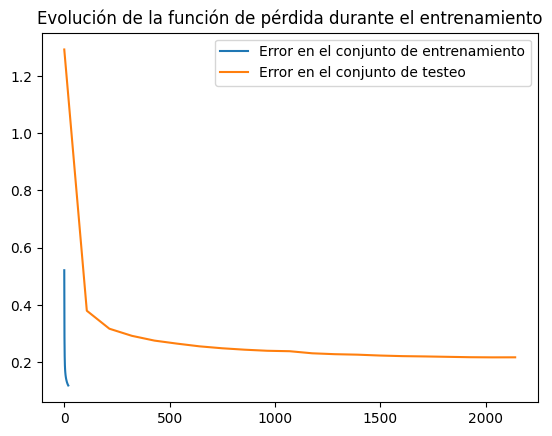

In [ ]:
plt.plot(lossi, label="Error en el conjunto de entrenamiento")
plt.plot(xs, lossi_test, label="Error en el conjunto de testeo")
plt.legend()
plt.title("Evolución de la función de pérdida durante el entrenamiento")
plt.show()

In [ ]:
with torch.no_grad():
    model.eval()
    for X_batch, Y_batch in test_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        outputs = model(X_batch, adj)
        loss_test = criterion(outputs, Y_batch)
        outputs_real = inverse_transform(outputs, mean, std)
        Y_real = inverse_transform(Y_batch, mean, std)
        X_real = inverse_transform(X_batch, mean, std)

In [ ]:
loss_test.item()

0.21390312910079956

In [ ]:
def plotear(pto_tiempo, num_sensor):
  a = X_real[pto_tiempo, :, num_sensor, :].squeeze().tolist()
  sig_real = Y_real[pto_tiempo, num_sensor, :].item()
  sig_pred = outputs_real[pto_tiempo, num_sensor, :].item()
  plt.plot(list(range(len(a))), a)
  plt.plot([len(a) - 1, len(a)], [a[-1], sig_real], 'r', label="Valor real")
  plt.plot([len(a) - 1, len(a)], [a[-1], sig_pred], 'g', label="Valor predicho")
  plt.legend()
  plt.title(f"Modelo GCN + LSTM\nPredicciones en el sensor {num_sensor}")
  plt.show()

In [ ]:
pto_tiempo = 3
num_sensor = 0

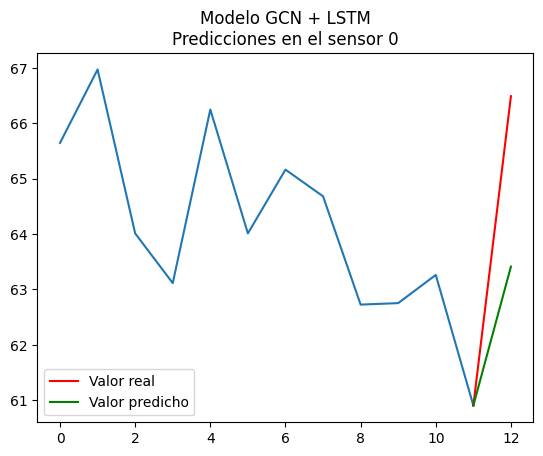

In [ ]:
plotear(pto_tiempo, num_sensor)

In [ ]:
pto_tiempo = 3
num_sensor = 100

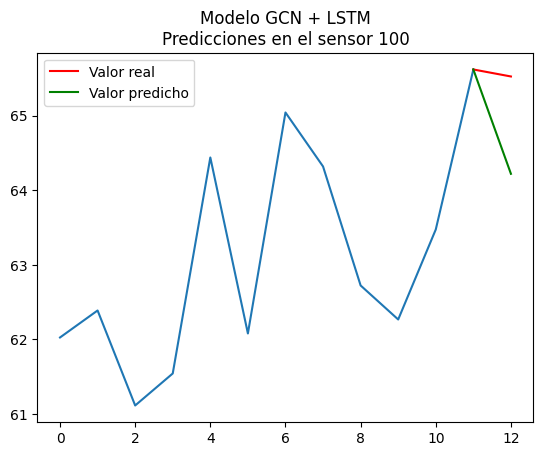

In [ ]:
plotear(pto_tiempo, num_sensor)

In [ ]:
def plotear_secuencia(num_sensor, ptos_a_predecir, pto_inicio=0):
  inicio = X_batch[pto_inicio, :, num_sensor, :].squeeze().tolist()
  siguientes = Y_batch[pto_inicio:ptos_a_predecir, num_sensor, :].squeeze().tolist()
  reales = inicio + siguientes
  predichos = [None] * 11 + [inicio[-1]] + outputs[pto_inicio:ptos_a_predecir, num_sensor, :].squeeze().tolist()
  plt.plot(reales, label="Valores reales")
  plt.plot(predichos, 'r', label="Valores predichos")
  plt.legend()
  plt.title(f"Modelo GCN + LSTM\nSerie de tiempo para el sensor {num_sensor}")
  plt.show

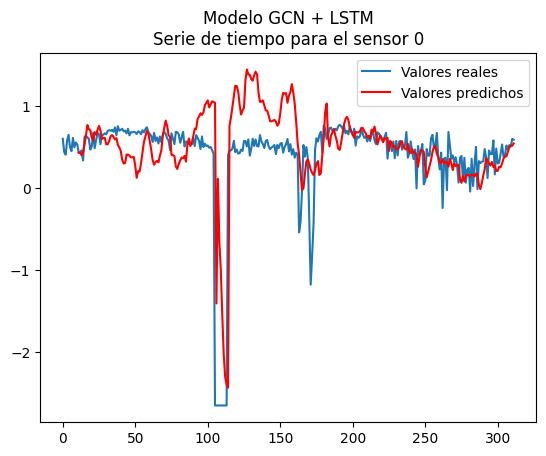

In [ ]:
plotear_secuencia(num_sensor, 300)

In [ ]:
torch.save(model, "modelos_entrenados/gcn_lstm.pt")

RuntimeError: Parent directory modelos_entrenados does not exist.